## Model Merging Technique and Implementation

Model merging is a cost-effective way to combine multiple models trained on different downstream taks, giving it the combined abilities of each individual model without any additional training.

#### This POC aims to explore the different types of LLM model merging techniques and discuss various examples of LLMs created through a merge operation.


 We will implement the merging operation using the mergekit library. Mergekit - https://github.com/arcee-ai/mergekit

### Merging Methods
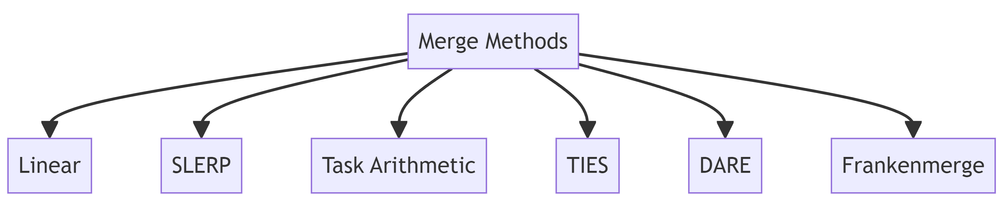

## Linear Merging ( Model Soup)


### The classic merge method - a simple weighted average.


The linear method uses a weighted average to combine two or more models, with the weight parameter allowing users to precisely control the contribution of each model's characteristics to the final merged model.


Parameters:

*weight* - relative (or absolute if normalize=False) weighting of a given tensor

*normalize* - if true, the weights of all models contributing to a tensor will be normalized.

Two types of model soup

- Uniform soup : Average all models
- Greedy Soup : Average models one by one, keeping only the ones that gradually improve test accuracy


In the below example , There is a CLIP ViT-B/32 and finetune on CIFAR10 with different hyperparamters and we tested those models on the test dataset to calculate the accuracy of each model

## Test accuracy of each model
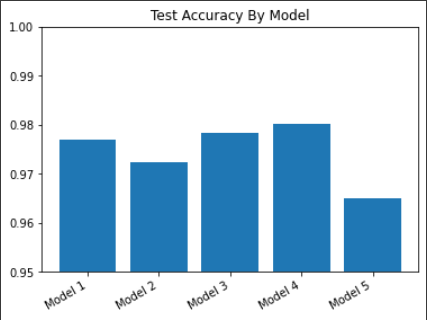

## Uniform Soup
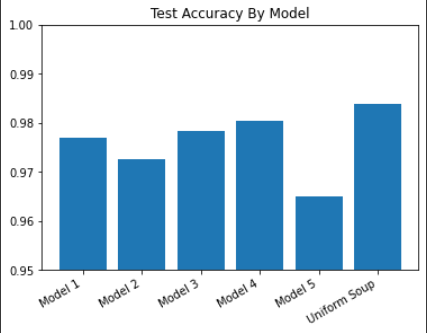




## Greedy Soup

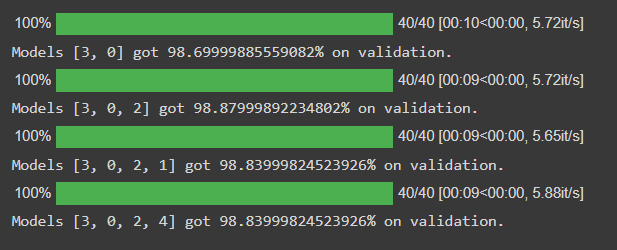


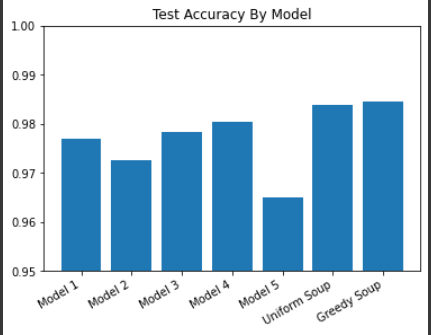

## Sample Merge KIT configuration for linear merging

In [ ]:
yaml_config="""
models:
  - model: psmathur/orca_mini_v3_13b
    parameters:
      weight: 0.2
  - model: WizardLM/WizardLM-13B-V1.2
    parameters:
      weight: 0.3
  - model: garage-bAInd/Platypus2-13B
    parameters:
      weight: 0.5
merge_method: linear
dtype: float16
"""

## SLERP ( Spherical Linear Interpolation)
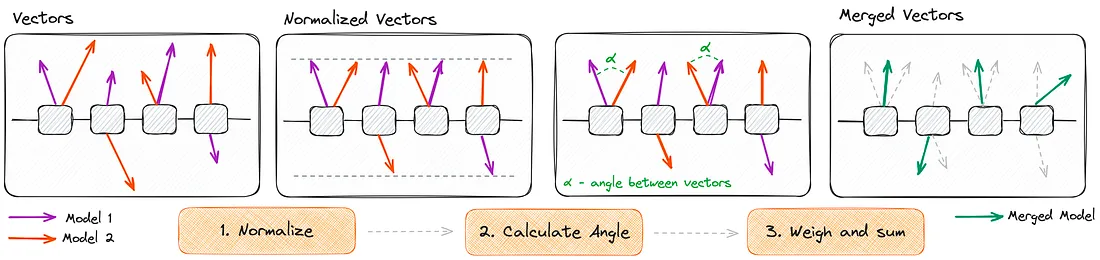



- SLERP addresses the limitations of traditional weight averaging in model merging. It offers a more nuanced approach, blending models in a way that preserves the unique characteristics and curvature of each parent model in high-dimensional spaces.

-  It can be applied to only 2 models at a time.

Three steps on SLERP

- Normalization
- Angle Calculation
- Vector Weighing and Summation




### Sample YAML configuration for SLERP

Parameters:

t - interpolation factor. At t=0 will return base_model, at t=1 will return the other one.

In [ ]:
yaml_config="""

slices:
  - sources:
      - model: psmathur/orca_mini_v3_13b
        layer_range: [0, 40]
      - model: garage-bAInd/Platypus2-13B
        layer_range: [0, 40]
merge_method: slerp
base_model: psmathur/orca_mini_v3_13b
parameters:
  t:
    - filter: self_attn
      value: [0, 0.5, 0.3, 0.7, 1]
    - filter: mlp
      value: [1, 0.5, 0.7, 0.3, 0]
    - value: 0.5 # fallback for rest of tensors
dtype: float16

"""



what does value: [1, 0.5, 0.7, 0.3, 0] mean? This is called the BlockMerge Gradient interpolation technique https://github.com/Gryphe/BlockMerge_Gradient?tab=readme-ov-file#gradient-values-gradient_values

Suppose we provide the gradient values as [1.0, 0.5, 0.0]. This tells the script to start by blending tensors with 100% of model2's values, gradually transition to a 50-50 blend between the two models, and finally, to use only model1's values.


## Task Arithmetic

This method introduces a new way for modifying the behavior of the model using “task vectors.” These vectors represent directions in the weight space of a pre-trained model, pointing towards improved performance on a specific task.

Vectors can be manipulated through arithmetic operations like negation and addition, allowing for targeted behavior changes in the model

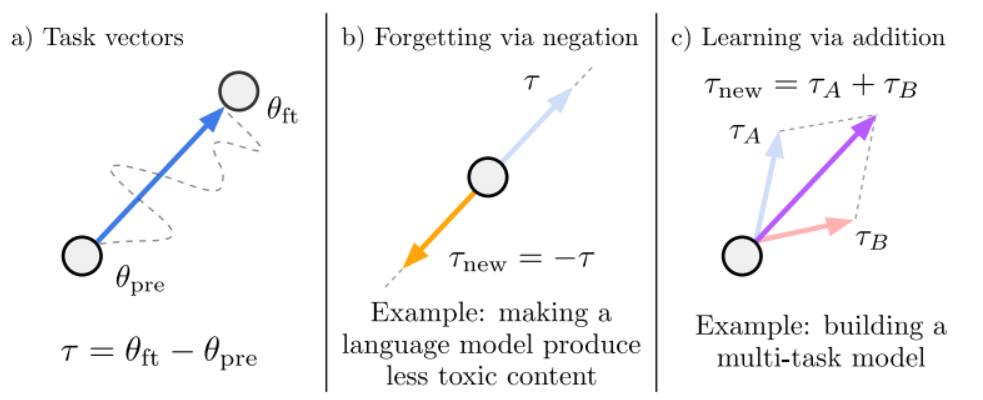


## Advantages of using Task Arithmetic merging

- Negation to Decrease Performance: Negating a task vector diminishes the model’s performance on the target task while maintaining its behavior on control tasks.

- Addition for Multi-Task Improvement: Adding task vectors can enhance the model’s performance across multiple tasks simultaneously

- Analogical Task Improvement: Combining task vectors from related tasks can improve performance on a fourth task, even without using data from this task.

### YAML configuration for Task Arithmetic Merging

In [ ]:
yaml_config="""
base_model: teknium/OpenHermes-2.5-Mistral-7B
dtype: bfloat16
merge_method: task_arithmetic
slices:
- sources:
  - layer_range: [0, 32]
    model: teknium/OpenHermes-2.5-Mistral-7B
  - layer_range: [0, 32]
    model: simonveitner/Math-OpenHermes-2.5-Mistral-7B
    parameters:
      weight: 0.25
  - layer_range: [0, 32]
    model: openaccess-ai-collective/dpopenhermes-alpha-v0
    parameters:
      weight: 0.25
  - layer_range: [0, 32]
    model: mlabonne/NeuralHermes-2.5-Mistral-7B
    parameters:
      weight: 0.25
  - layer_range: [0, 32]
    model: mlabonne/NeuralHermes-2.5-Mistral-7B-laser
    parameters:
      weight: 0.25
"""

### TRIM, ELECT SIGN & MERGE (TIES-Merging)


TIES-merging is currently the most popular model merging method in the LLM community due to its ability to merge more than two models simultaneously.

The TIES-Merging method utilizes the task arithmetic framework to efficiently combine multiple task-specific models into a single multitask model, addressing the challenges of parameter interference and redundancy

The TIES-Merging method minimizes the loss of valuable information due to redundant parameter values and sign disagreements across models, which specifies task vectors and applies a sign consensus algorithm..

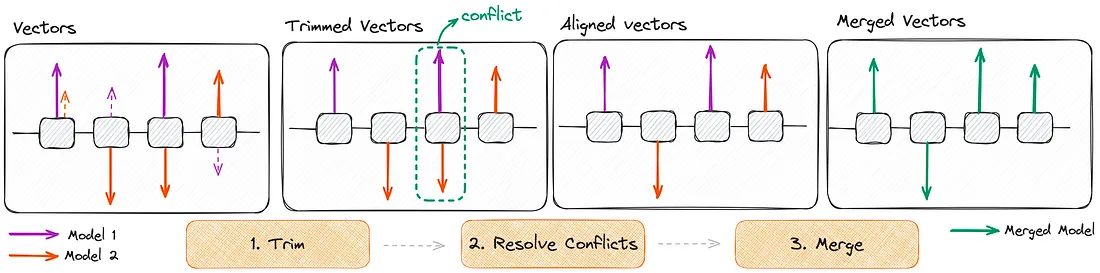

- Resetting Parameters: It resets parameters that have only changed marginally during fine-tuning. This step helps in reducing redundancy.
- Resolving Sign Conflicts: It resolves conflicts arising from differing signs of parameter values across models.
- Selective Merging: It merges only those parameters that align with the final agreed-upon sign.

### YAML Configuration for TIES

Parameters: same as Linear, Additionally:

density - Defines the fraction of most significant parameters from each model that should be retained in the merged model

In [ ]:
yaml_config="""
models:
  - model: psmathur/orca_mini_v3_13b
    parameters:
      density: [1, 0.7, 0.1] # density gradient
      weight: 1.0
  - model: garage-bAInd/Platypus2-13B
    parameters:
      density: 0.5
      weight: [0, 0.3, 0.7, 1] # weight gradient
  - model: WizardLM/WizardMath-13B-V1.0
    parameters:
      density: 0.33
      weight:
        - filter: mlp
          value: 0.5
        - value: 0
merge_method: ties
base_model: TheBloke/Llama-2-13B-fp16
parameters:
  normalize: true
  int8_mask: true
dtype: float16
"""

### DARE TIES/Task Arithmetic ( DROP AND RESCALE)


DARE primarily focuses on learning the parameters of similar models to gain new capabilities.

It uses a similar approach to TIES with two main differences:

Pruning of Delta Parameters: identifies and eliminates most delta parameters (the differences between fine-tuned and pre-trained parameters) by setting them to zero.


Rescaling Weights: includes a rescaling step where the weights of the models are adjusted to keep the output expectations approximately unchanged. This involves adding the rescaled weights of the models to the weights of the base model with a scale factor.

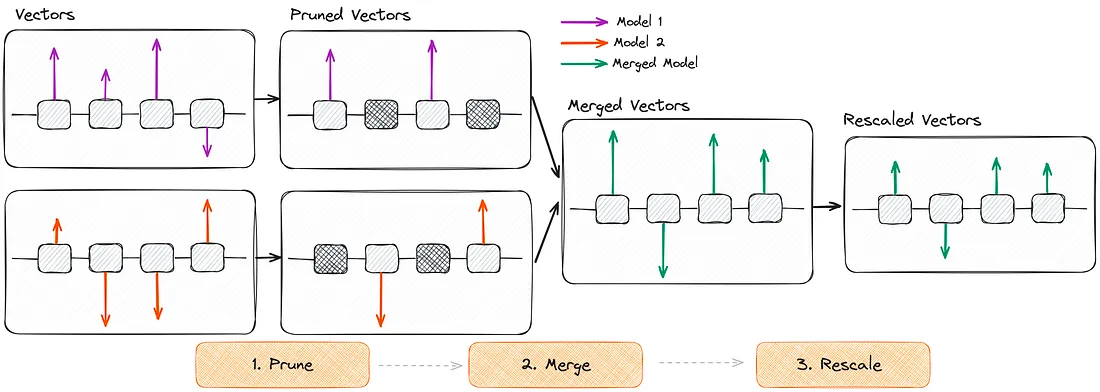

- Pruning: resets fine-tuned weights to their original pre-trained values, reducing unnecessary parameter changes.
- Merging: averages parameters from multiple models to create a single, unified model.
- Rescaling: adjusts the merged model’s weights to preserve its expected performance.e.

### YAML Configuration for DARE merging

Mergekit's implementation of this method has two flavours: with the sign election step of TIES (dare_ties) or without (dare_linear).

In [ ]:

yaml_config="""

models:
  - model: mistralai/Mistral-7B-v0.1
    # No parameters necessary for base model
  - model: samir-fama/SamirGPT-v1
    parameters:
      density: 0.53
      weight: 0.4
  - model: abacusai/Slerp-CM-mist-dpo
    parameters:
      density: 0.53
      weight: 0.3
  - model: EmbeddedLLM/Mistral-7B-Merge-14-v0.2
    parameters:
      density: 0.53
      weight: 0.3
merge_method: dare_ties
base_model: mistralai/Mistral-7B-v0.1
parameters:
  int8_mask: true
dtype: bfloat16
"""

### FrankenMerges (Passthrough)

This method concatenates layers from different models, enabling the creation of models with a unique number of parameters, such as combining two 7B models to form a 9B model

Passthrough is a no-op that simply passes input tensors through unmodified. It is meant to be used for layer-stacking type merges where we have only one input model.

Currently, this is the only method in Mergekit that works for different model architectures. This is because it doesn’t fuse different layers into a single one as other methods do, and instead just stacks different layers sequentially.

### YAML config for passthorugh merging

In [ ]:
yaml_config="""
slices:
  - sources:
    - model: mistralai/Mistral-7B-v0.1
      layer_range: [0, 24]
  - sources:
    - model: mistralai/Mistral-7B-v0.1
      layer_range: [8, 32]
merge_method: passthrough
dtype: bfloat162
"""

## Implementation using MergeKit Library

In [ ]:
!git clone https://github.com/cg123/mergekit.git
!cd mergekit && pip install -q -e .

Cloning into 'mergekit'...
remote: Enumerating objects: 2260, done.
remote: Counting objects: 100% (1349/1349), done.
remote: Compressing objects: 100% (525/525), done.
remote: Total 2260 (delta 1072), reused 935 (delta 823), pack-reused 911
Receiving objects: 100% (2260/2260), 641.12 KiB | 6.05 MiB/s, done.
Resolving deltas: 100% (1575/1575), done.
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.9/394.9 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.9/96.9 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 8.4 MB/s eta

### Combining two different models: OpenMath-Mistral-7B-v0.1-hf and Mistral-7B-Merge-14-v0.1 and merge them with the SLERP method

Model links

OpenMath - https://huggingface.co/nvidia/OpenMath-Mistral-7B-v0.1-hf


EmbeddedLLM - https://huggingface.co/EmbeddedLLM/Mistral-7B-Merge-14-v0.1



In [ ]:
import yaml

MODEL_NAME = "OpenMath-Mistral-7B-Merge-14-v0.1"
yaml_config = """
slices:
  - sources:
      - model: nvidia/OpenMath-Mistral-7B-v0.1-hf
        layer_range: [0, 32]
      - model: EmbeddedLLM/Mistral-7B-Merge-14-v0.1
        layer_range: [0, 32]
merge_method: slerp
base_model: EmbeddedLLM/Mistral-7B-Merge-14-v0.1
parameters:
  t:
    - filter: self_attn
      value: [0, 0.5, 0.3, 0.7, 1]
    - filter: mlp
      value: [1, 0.5, 0.7, 0.3, 0]
    - value: 0.5
dtype: bfloat16
"""

# Save config as yaml file
with open('config.yaml', 'w', encoding="utf-8") as f:
    f.write(yaml_config)

### Mergekit command to combine the models

--**copy-tokenizer** to copy the tokenizer from the base model

--**allow-crimes** and --out-shard-size to chunk the models into smaller shards that can be computed on a CPU with low RAM

--**lazy-unpickle** to enable the experimental lazy unpickler for lower memory usage
In addition, some models can require the --trust_remote_code flag (this is not the case with Mistral-7B).


--**cuda enables** the matrix arithmetic on GPU.

--**copy-tokenizer** enables copying a tokenizer to the output.

--**allow-crimes** enables mixing of architectures.

--**out-shard-size** <size> specifies the number of parameters per output shard of the model. Default is set at 5B.


In [ ]:
# Merge models
!mergekit-yaml config.yaml merge --copy-tokenizer --allow-crimes --out-shard-size 1B --lazy-unpickle

Streaming output truncated to the last 5000 lines.
model-00001-of-00002.safetensors:   7% 724M/9.98G [00:11<04:32, 34.0MB/s]

model-00002-of-00002.safetensors:  16% 713M/4.51G [00:12<01:12, 52.0MB/s]



model-00001-of-00002.safetensors:   7% 744M/9.98G [00:12<03:12, 48.0MB/s]



model-00001-of-00002.safetensors:   8% 755M/9.98G [00:12<03:30, 43.7MB/s]

model-00002-of-00002.safetensors:  16% 724M/4.51G [00:12<01:31, 41.4MB/s]

model-00002-of-00002.safetensors:  17% 744M/4.51G [00:12<01:12, 52.1MB/s]



model-00001-of-00002.safetensors:   8% 776M/9.98G [00:12<02:53, 53.1MB/s]

model-00002-of-00002.safetensors:  17% 755M/4.51G [00:12<01:08, 54.9MB/s]



model-00001-of-00002.safetensors:   8% 786M/9.98G [00:13<03:24, 45.0MB/s]

model-00002-of-00002.safetensors:  17% 776M/4.51G [00:13<01:05, 57.2MB/s]

model-00002-of-00002.safetensors:  18% 797M/4.51G [00:13<00:52, 70.5MB/s]



model-00001-of-00002.safetensors:   8% 807M/9.98G [00:13<03:05, 49.6MB/s]

model-00002-of-00002.safetensors:  18% 

In [ ]:
from huggingface_hub import ModelCard, ModelCardData
from jinja2 import Template

username = "Goutham-Vignesh"

template_text = """
---
license: apache-2.0
tags:
- merge
- mergekit
- lazymergekit
{%- for model in models %}
- {{ model }}
{%- endfor %}
---

# {{ model_name }}

{{ model_name }} is a merge of the following models using [mergekit](https://github.com/cg123/mergekit):

{%- for model in models %}
* [{{ model }}](https://huggingface.co/{{ model }})
{%- endfor %}

## 🧩 Configuration

\```yaml
{{- yaml_config -}}
\```
"""

# Create a Jinja template object
jinja_template = Template(template_text.strip())

# Get list of models from config
data = yaml.safe_load(yaml_config)
if "models" in data:
    models = [data["models"][i]["model"] for i in range(len(data["models"])) if "parameters" in data["models"][i]]
elif "parameters" in data:
    models = [data["slices"][0]["sources"][i]["model"] for i in range(len(data["slices"][0]["sources"]))]
elif "slices" in data:
    models = [data["slices"][i]["sources"][0]["model"] for i in range(len(data["slices"]))]
else:
    raise Exception("No models or slices found in yaml config")

# Fill the template
content = jinja_template.render(
    model_name=MODEL_NAME,
    models=models,
    yaml_config=yaml_config,
    username=username,
)

# Save the model card
card = ModelCard(content)
card.save('merge/README.md')

## Push the model to the huggingface Hub

Huggingface Model Card Link - https://huggingface.co/Goutham-Vignesh/OpenMath-Mistral-7B-Merge-14-v0.1

In [ ]:
from google.colab import userdata
from huggingface_hub import HfApi

username = "Goutham-Vignesh"

# Defined in the secrets tab in Google Colab
api = HfApi(token="---- Add Your huggingface Token Here ----")

api.create_repo(
    repo_id=f"{username}/{MODEL_NAME}",
    repo_type="model"
)
api.upload_folder(
    repo_id=f"{username}/{MODEL_NAME}",
    folder_path="merge",
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model-00002-of-00015.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

model-00001-of-00015.safetensors:   0%|          | 0.00/961M [00:00<?, ?B/s]

model-00003-of-00015.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

Upload 16 LFS files:   0%|          | 0/16 [00:00<?, ?it/s]

model-00004-of-00015.safetensors:   0%|          | 0.00/998M [00:00<?, ?B/s]

model-00005-of-00015.safetensors:   0%|          | 0.00/948M [00:00<?, ?B/s]

model-00006-of-00015.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

model-00007-of-00015.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

model-00008-of-00015.safetensors:   0%|          | 0.00/998M [00:00<?, ?B/s]

model-00009-of-00015.safetensors:   0%|          | 0.00/948M [00:00<?, ?B/s]

model-00010-of-00015.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

model-00011-of-00015.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

model-00012-of-00015.safetensors:   0%|          | 0.00/998M [00:00<?, ?B/s]

model-00013-of-00015.safetensors:   0%|          | 0.00/948M [00:00<?, ?B/s]

model-00014-of-00015.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

model-00015-of-00015.safetensors:   0%|          | 0.00/755M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Goutham-Vignesh/llava1.6-Mistral-7B-Merge-14-v0.1/commit/61ead361ec1d7d3fcfb24bedbe5fde4e6e148c66', commit_message='Upload folder using huggingface_hub', commit_description='', oid='61ead361ec1d7d3fcfb24bedbe5fde4e6e148c66', pr_url=None, pr_revision=None, pr_num=None)

### Inference Check

In [ ]:
from transformers import AutoTokenizer
import transformers
import torch

model = "Goutham-Vignesh/OpenMath-Mistral-7B-Merge-14-v0.1"

tokenizer = AutoTokenizer.from_pretrained(model)


messages = [{"role": "user", "content": "In a dance class of 20 students, 20% enrolled in contemporary dance, 25% of the remaining enrolled in jazz dance, and the rest enrolled in hip-hop dance. What percentage of the entire students enrolled in hip-hop dance?"}]


prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
pipeline = transformers.pipeline(
    "text-generation",
    model=model,
    torch_dtype=torch.float16,
    device_map="auto",
)

outputs = pipeline(prompt, max_new_tokens=1024, do_sample=True, temperature=0.7, top_k=50, top_p=0.95)
print(outputs[0]["generated_text"])

### Output Answer

In a dance class of 20 students, 20% enrolled in contemporary dance, 25% of the remaining enrolled in jazz dance, and the rest enrolled in hip-hop dance. What percentage of the entire students enrolled in hip-hop dance?
 Let's solve this problem step by step.

First, we need to calculate the number of students enrolled in each dance style.

20% of the entire class enrolled in contemporary dance, so 20% of 20 students, which is 4 students, enrolled in contemporary dance.

25% of the remaining students enrolled in jazz dance. Since 4 students enrolled in contemporary dance, the remaining students are 20 - 4 = 16 students. 25% of 16 students is 4 students, so 4 students enrolled in jazz dance.

The rest of the students enrolled in hip-hop dance. Since 4 students enrolled in jazz dance, the number of students enrolled in hip-hop dance is 20 - 4 - 4 = 12 students.

Now, we need to calculate the percentage of students enrolled in hip-hop dance. To do this, we divide the number of students enrolled in hip-hop dance (12) by the total number of students (20) and multiply by 100 to get the percentage.

12 / 20 * 100 = 60

So, 60% of the entire students enrolled in hip-hop dance.

The answer is: 60%

## Further Improvements



*   Evaluate the Merged model accross multiple benchmarking dataset

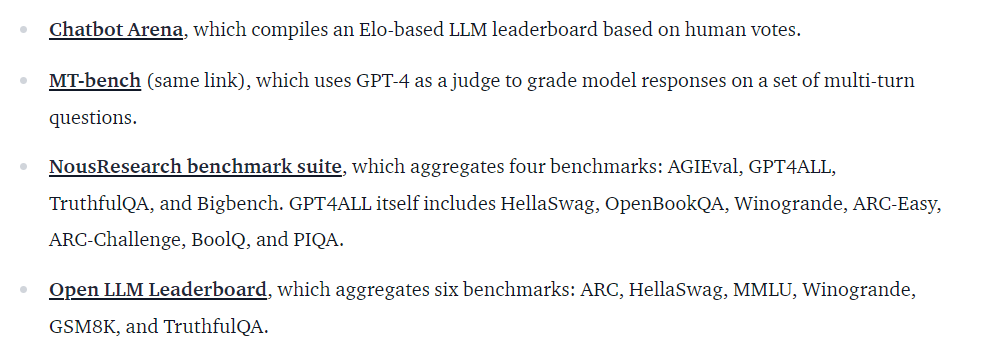

*   Check out merging of models with different base architecture
*   Create a Huggingface Space or Streamlit UI for our internal model merging experiments



Model Family Tree Space - https://huggingface.co/spaces/mlabonne/model-family-tree